# Importações

In [1]:
import pandas as pd
import math
import networkx as nx
import matplotlib.pyplot as plt

# Load do arquivo para criação da rede
### Aqui vamos consultar informações de lat e long 

In [2]:
#Renomeia as colunas, busca os dados Lat e Long e cria o cabeçalho que não havia
airport_col = ['ID', 'Name', 'City', 'Country','Sigla_cidade', 'Sigla_airport', 'Lat', 'Long', 'Alt', 
	               'GMT', 'S', 'Zona  UTM', 'tipo', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat", names = airport_col, index_col = 0)
airport_df[airport_df.Country == 'Brazil'].head(10)

,Name,City,Country,Sigla_cidade,Sigla_airport,Lat,Long,Alt,GMT,S,Zona UTM,tipo,source
ID,,,,,,,,,,,,,
2518,Conceição do Araguaia Airport,Conceicao Do Araguaia,Brazil,CDJ,SBAA,-8.348350,-49.301498,653,-3,S,America/Belem,airport,OurAirports
2519,Campo Délio Jardim de Mattos Airport,Rio De Janeiro,Brazil,\N,SBAF,-22.875099,-43.384701,110,-3,S,America/Sao_Paulo,airport,OurAirports
2520,Amapá Airport,Amapa,Brazil,\N,SBAM,2.077510,-50.858200,45,-3,S,America/Fortaleza,airport,OurAirports
2521,Araraquara Airport,Araracuara,Brazil,AQA,SBAQ,-21.812000,-48.132999,2334,-3,S,America/Sao_Paulo,airport,OurAirports
2522,Santa Maria Airport,Aracaju,Brazil,AJU,SBAR,-10.984000,-37.070301,23,-3,S,America/Fortaleza,airport,OurAirports
2524,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,AFL,SBAT,-9.866389,-56.105000,948,-4,S,America/Campo_Grande,airport,OurAirports
2525,Araçatuba Airport,Aracatuba,Brazil,ARU,SBAU,-21.141300,-50.424702,1361,-3,S,America/Sao_Paulo,airport,OurAirports
2526,Val de Cans/Júlio Cezar Ribeiro International ...,Belem,Brazil,BEL,SBBE,-1.379250,-48.476299,54,-3,S,America/Belem,airport,OurAirports
2527,Comandante Gustavo Kraemer Airport,Bage,Brazil,BGX,SBBG,-31.390499,-54.112202,600,-3,S,America/Sao_Paulo,airport,OurAirports


## Busca Lat e Long

In [3]:
#Busca as possíveis coordenadas dos aeroportos a partir da Abreviação da Cidade
def monta_pos(Sigla_cidade):
    airport_pos_df = airport_df.loc[airport_df['Sigla_cidade'].isin(Sigla_cidade)][['Sigla_cidade', 'Lat', 'Long']] #Filtra o dataframe de acordo com o input
    airport_pos_df.reset_index(inplace=True) #Cria uma coluna a esquerda com o antigo index
    
    position = {}
    for index, elem in enumerate (airport_pos_df['Sigla_cidade']):    #Cria um dicionário com todos os aeroportos localizados
        position[elem] =  (airport_pos_df.loc[index ,'Long'], airport_pos_df.loc[index ,'Lat']) 
    
    found = len(airport_pos_df.loc[~airport_pos_df['Lat'].isnull()]) #Retorna o número de aeroportos
    print(f'{found} Aeroportos com Lat, Long')  
    
    return position

## Cria rotas, e prepara a lista de aeroportos

In [4]:

def routes_top(routes_grouped_df, top):
    routes_grouped_df_top = routes_grouped_df.loc[routes_grouped_df['counts'] > top]  
    
    origem = set(routes_grouped_df_top['origem'].unique())  
    print(f'{len(origem)} Aeroportos encontrados (Origem)')
    
    destino = set(routes_grouped_df_top['destino'].unique())
    print(f'{len(destino)} Aeroportos encontrados (Destinos)')

    airport = destino.union(origem)
    print(f'{len(airport)} Aeroportos encontrados no total')
    
    return airport, routes_grouped_df_top

# Estruturação das rotas (arestas)

In [5]:
def monta_rotas(top):
    routes_col = ['id_empresa', 'no_voo', 'cod_auth', 'cod_tipo','origem', 'destino', 
                'partida_estimada', 'partida_real', 'chegada_prevista', 'chegada_real', 
                'status_voo', 'obs', 'ano', 'mes']

    #Carrega o arquivo csv direto do Github do professor Luciano (lucianomcsilva)
    routes_df = pd.read_csv(f"https://github.com/lucianomcsilva/VRA/blob/main/VRA_ANO_2018.csv.zip?raw=true"
                            ,compression='zip' ,header=0 ,names = routes_col, index_col = 0)

    routes_df = routes_df.loc[routes_df['status_voo'] != 'CANCELADO'] #bussca apenas voos realizados

    #Agrupa as informações de origem e destino para geração do grafo
    routes_grouped_df = routes_df.groupby(['origem', 'destino']).size().reset_index(name='counts')                          
    
    ######################################################################
    #Jaz a junção com o Airport.dat para trocar para o codigo de 3 letras
    ######################################################################
    
    #Join origem
    routes_grouped_df = routes_grouped_df.merge(airport_df[['Sigla_airport', 'Sigla_cidade', 'Lat', 'Long', 'Country']], 
                                                how='left', left_on='origem', right_on='Sigla_airport')
    routes_grouped_df = routes_grouped_df[['Sigla_cidade', 'Country', 'destino', 'counts']]
    routes_grouped_df.rename(columns={'Sigla_cidade': 'origem', 'Country': 'Country_orig'}, inplace = True)
    
    #Join Destino
    routes_grouped_df = routes_grouped_df.merge(airport_df[['Sigla_airport', 'Sigla_cidade', 'Lat', 'Long', 'Country']], 
                                                how='left', left_on='destino', right_on='Sigla_airport')
    routes_grouped_df = routes_grouped_df[['origem', 'Country_orig', 'Sigla_cidade', 'Country', 'counts']]
    routes_grouped_df.rename(columns={'Sigla_cidade': 'destino', 'Country': 'Country_dest'}, inplace = True)

    #Filtra somente Brazil, e mantem somente as colunas necessarias
    routes_grouped_df = (routes_grouped_df
                        .loc[routes_grouped_df['Country_orig'] == 'Brazil']
                        .loc[routes_grouped_df['Country_dest'] == 'Brazil']
                        .loc[routes_grouped_df['origem'] != routes_grouped_df['destino']]
                        .loc[routes_grouped_df['origem'].str.len() == 3]
                        .loc[routes_grouped_df['destino'].str.len() == 3]
                        .sort_values(by=['counts'], ascending=False)
                      )
    routes_grouped_df = routes_grouped_df[['origem', 'destino', 'counts']]  
    
    #prepara os DataFrames que serão utilizados
    airport, routes_grouped_df_top = routes_top(routes_grouped_df, top)
    position = monta_pos(airport)
    
    return routes_grouped_df_top, position

  #lista de aeroportos nao encontrados
  #routes_grouped_df.loc[routes_grouped_df['ICAO'].isnull()]['ICAO_orig'].to_list()
  #df_anac_2015 = pd.read_csv(f"VRA_ANO_2015.csv")

# Montagem do grafo

In [6]:
routes, position = monta_rotas(1) # 1 = melhor rota, ou seja, menor distância ate o outro nó
routes.reset_index(inplace=True)
#display(len(routes))
#display(len(position))

C:\Users\User\AppData\Local\Temp\ipykernel_6600\2372826177.py:7: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  routes_df = pd.read_csv(f"https://github.com/lucianomcsilva/VRA/blob/main/VRA_ANO_2018.csv.zip?raw=true"


116 Aeroportos encontrados (Origem)
117 Aeroportos encontrados (Destinos)
118 Aeroportos encontrados no total
118 Aeroportos com Lat, Long


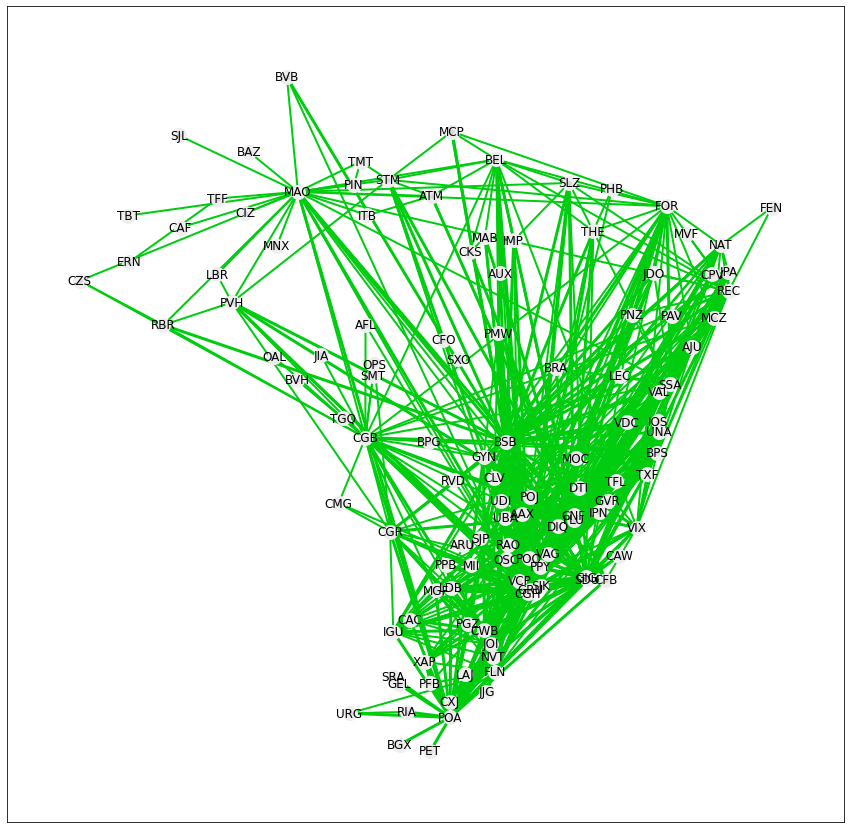

In [7]:
G = nx.Graph()
airport_brasil_df = airport_df.loc[airport_df['Country'] == 'Brazil'].loc[airport_df['Sigla_cidade'].str.len() == 3]
airport_brasil_df.reset_index(inplace=True)

for index, elem in enumerate(routes['origem']):
    G.add_edge(routes.loc[index, 'origem'], routes.loc[index, 'destino'])

options = {
    "font_size": 12,
    "node_size": 100,
    "node_color": "#D9D9D9",
    "edgecolors": "#EEEEEE",
    "edge_color": "#00CC10",
    "linewidths": 5,
    "width": [1+int(math.log(x, 30)) for x in routes['counts'].to_list()],
    "with_labels": True
}

plt.figure(figsize = (15,15))
nx.draw_networkx(G, position, **options)
#plt.savefig(f'brasil_2_map_{ano}.png', dpi=50)

## Qual o grau médio, ou seja, número de outros aeroportos conectados, dos aeroportos brasileiros com voos em 2018?

In [8]:
degrees_dict = { u: G.degree(u) for u in G.nodes }

df = pd.DataFrame(degrees_dict.items(), columns=['aeroporto','rotas'])
print('O grau médio é', round(df['rotas'].mean()))

O grau médio é 10


## Qual aeroporto brasileiro voava, em 2018, para mais cidades distintas?

In [9]:
aeroporto = df.nlargest(1, 'rotas')
print('O aeroporto com mais rotas distintas é', aeroporto.iloc[0]['aeroporto'], 'com', aeroporto.iloc[0]['rotas'])

O aeroporto com mais rotas distintas é VCP com 67


## Quais são os dois aeroportos que precisavam em 2018 de mais escalas para se interligarem?

In [10]:
escalas = list(nx.shortest_path_length(G))
df3 = pd.DataFrame(columns=['origem','destino','conexoes'])

for i in range(len(escalas)):
    origem = escalas[i][0]
    aero_mais_escalas = max(escalas[i][1], key=escalas[i][1].get)
    qtd_escalas = max(escalas[i][1].values())
    df_temp = pd.DataFrame([[origem,aero_mais_escalas,qtd_escalas]], columns=['origem','destino','conexoes'])
    df3 = df3.append(df_temp)
    
df3['conexoes'] = df3['conexoes'].astype(float)
df3_max = df3.nlargest(1, 'conexoes')

df3 = df3[df3['conexoes'] == df3_max.iloc[0]['conexoes']]
print('Os aeroportos que precisam de mais escalas para se interligarem são: \n')

for i in range(len(df3)):
    print('De', df3.iloc[i]['origem'], 'para', df3.iloc[i]['destino'], 'com', round(df3.iloc[i]['conexoes']), 'conexões')

C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append

C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append

C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append

Os aeroportos que precisam de mais escalas para se interligarem são: 

De AUX para ERN com 5 conexões
De TFL para ERN com 5 conexões
De DTI para ERN com 5 conexões
De ERN para AUX com 5 conexões
De POO para ERN com 5 conexões
De PPY para ERN com 5 conexões


C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df_temp)
C:\Users\User\AppData\Local\Temp\ipykernel_6600\3411930874.py:9: FutureWarning: The frame.append